In [1]:
from dotenv import load_dotenv
import os

from langchain.chat_models import ChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.prompts.chat import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate, AIMessagePromptTemplate
from langchain import LLMChain

import pandas as pd

In [2]:
load_dotenv(r'E:\Documentos\Estudos\UFRJ_PESC\3_periodo\llm\projeto final\COS836-2023-2-LLM\src\utils\openai_api_key.env')  # take environment variables from .env.
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [3]:
chat_t1 = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model_name="gpt-4", temperature=1)

In [4]:
sys_nodes_edges_template = """
- Step 1:
Think concisely about an original and engaging world. You should consider the following aspects, but never talk about them directly:
    - The genre is {genre};
    - The world brings {feels};
    - The tone of the story is {tone};
    - The level of technology is {technology};
    - Magic is seen as {magic};
    - The atmosphere is {atmosphere};
    - The story is inspired by {writters};
    - The story is inspired by the universe of {universes}.
    - The story deals with more or less 4 of the following subjects: Governance and its influence, Legal principles and rule of law, Provision of social services, Economic dynamics, Equity in wealth distribution, Agricultural practices and trade, Interpersonal relationships influenced by race, class, gender or sexual orientation, Military power and influence, Role and influence of religion, Technological advances and influences, Impact of arts and cultural expressions, Geographical features, Interactions between civilizations, their histories and conflicts, Foundations of the laws of nature, Theories about the origin of the universe, History of species and cultures that have inhabited the world, Needs and interactions of different species and cultures.
    - When describing any entity (location, object, character, species, condition, conflict, organization, title, myth, etc.), you must provide specific names and brief descriptions.

- Step 2:
Find the main topics in this story, that could be better developed, and think of a list of topics and a brief explanation of each.

- Step 3:
Identify the entities in the text. An entity can be a noun or a noun phrase that refers to a real-world object or an abstract concept. You can use a named entity recognition (NER) tool or a part-of-speech (POS) tagger to identify the entities.
Each entity should have a name, a label, and a detailed description. The label can be one of the following:

- Place: Physical places, such as continents, cities, mountains, or forests;
- Building: Natural constructions and formations. Examples: house, dungeon, cave, castle;
- Vehicle: Means of transportation. Example: car, ship, bicycle.
- Character: Individuals or animals in specific roles. Examples: hero, villain, guard, pet.
- Item: Tangible items or documents. Examples: weapons, clothes, letters, and books.
- Species: Biological or cultural groups. Examples: elves, humans, and dogs.
- Organization: Groups with common purposes. Examples: churches, governments, and sects.
- Condition: Physical or emotional states. Examples: illness, inspiration, sadness.
- Drama: Challenges, sociocultural tensions, or military conflicts. Examples: military influence, class relations, and economic problems.
- Myth: Narratives, beliefs, or prose. Examples: legends about the origin of the universe, and myths of monsters.

- Step 4
Identify the relationships between the entities. A relationship can be a verb or a prepositional phrase that connects two entities. You can use dependency parsing to identify the relationships.
The relationships should be represented by triplets of subject, predicate, and object, where the subject and object are entities mapped in the last step and the predicate can have the following labels:

\1 IS_IN: Represents location or use.
    \2 Possible subjects and objects:
        \3 Buildings => Locations
        \3 Vehicles => Locations/Buildings
        \3 Characters => Locations/Buildings/Vehicles
        \3 Items => Locations/Buildings/Vehicles/Characters
\1 OWNER_OF: Denotes direct ownership.
    \2 Possible subjects and objects:
        \3 Characters/Organizations => Locations/Buildings/Vehicles/Characters/Items
\1 POSITIVE/NEGATIVE/NEUTRAL_RELATIONSHIP: Denotes an interpersonal interaction or bond.
    \2 Possible subjects and objects:
        \3 Characters/Organizations => Characters/Organizations
\1 AFFECTED_BY: Shows entities impacted by conditions or conflicts.
    \2 Possible subjects and objects:
        \3 Characters => Conditions/Drama
        \3 Organizations => Drama
\1 MEMBER_OF: It indicates belonging to groups, categories, or organizations.
    \2 Possible subjects and objects:
        \3 Characters => Organizations/Species
\1 BASED_ON: Links entities to stories, myths, legends, or cultural influences.
    \2 Possible subjects and objects:
        \3 Anything => Myths
        \3 Organizations => Drama
\1 SUCCEEDS/PRECEDES: It represents what comes after/before in a time sequence.
    \2 Possible subjects and objects:
        \3 Myths/Drama => Myths/Drama

Find as many relationships as possible within these limitations.

- Step 5
Make a dictionary of lists, that contains a list of nodes, that represent the entities found in Step 3, and e a list of edges, that represent a knowledge graph, with the relations found in Step 4.
___
Example of list of edges:
[('Name of Entity A', 'Name of Entity B',{{'relation':'RELATIONSHIP_1'}}),
 ('Name of Entity C', "Entity Name A",{{'relation':'RELATIONSHIP_2'}})]
___
Example of list of nodes:
[('Name of Entity A', {{'label': 'Label A', 'description': 'Description A'}}),
 ('Name of Entity B', {{'label': 'Label B', 'description': 'Description B'}}),
 ('Name of Entity C', {{'label': 'Label C', 'description': 'Description C'}})]
__
Example of dictionary of lists (generate different examples but with the same structure):
{{nodes: [('Name of Entity A', {{'label': 'Label A', 'description': 'Description A'}}),
          ('Name of Entity B', {{'label': 'Label B', 'description': 'Description B'}}),
          ('Name of Entity C', {{'label': 'Label C', 'description': 'Description C'}})],
 edges: [('Name of Entity A', 'Name of Entity B',{{'relation':'RELATIONSHIP_1'}}),
         ('Name of Entity C', "Entity Name A",{{'relation':'RELATIONSHIP_2'}})]}}

The list of nodes and edges will be used in NetworkX.

You must never explain your code.
__
Create {places} places, {buildings} buildings, {vehicles} vehicles, {characters} characters, {items} items, {species} species, {organizations} organizations, {conditions} conditions, {dramas} dramas, {myths} myths, and as many relationships (edges) as you need.
Items, Buildings, Vehicles, and Characters need at least one relationship of type IS_IN.
Myths need at least one BASED_ON relationship.
Species and Organizations need at least one MEMBER_OF relationship.
"""

In [5]:
usr_nodes_edges = "Do not write anything about steps 1, 2, 3, 4. Return only the result of steps 5."

In [6]:
genre = "cyberpunk fantasy"
feels = "a hopeless feeling"
tone = "dark"
technology = "futuristic"
magic = "something ultra-rare and forgotten"
atmosphere = "dystopic"
writters = "Isaac Asimov, Greg Bear, Frank Herbert, William Gibson, Philip K. Dick"
universes = "Cyberpunk 2077, Lancer RPG, BladeRunner, Ghost in the Shell, Cowboy Bebop"

places = 1
buildings = 8
vehicles = 1
characters = 16
items = 2
species = 3
organizations = 3
conditions = 1
dramas = 2
myths = 2

In [7]:
sys_nodes_edges_msg = SystemMessagePromptTemplate.from_template(sys_nodes_edges_template)
chat_prompt = ChatPromptTemplate.from_messages([sys_nodes_edges_msg,
                                                HumanMessage(content=usr_nodes_edges)])
chain = LLMChain(llm=chat_t1, prompt=chat_prompt)

ValueError: unmatched '{' in format spec

In [ ]:
nodes_edges = chain.run(genre=genre, feels=feels, tone=tone, technology=technology, magic=magic, atmosphere=atmosphere,
                        writters=writters, universes=universes,
                        places=places, buildings=buildings, vehicles=vehicles, characters=characters, items=items,
                        species=species, organizations=organizations, conditions=conditions, dramas=dramas, myths=myths)

In [16]:
print(nodes_edges)

CREATE
(irith:Place{name: "Irith", description: "A sprawling mega city in a world where technology shadows remnants of magic."}),
(encoreTowers:Building{name: "Encore Towers", description: "A mass of steel and glass, an affluent symbol of relentless progress."}),
(abandonedShrine:Building{name: "Abandoned Shrine", description: "Decaying evidence of an era where magic was worshipped, now forgotten."}),
(blackmarePub:Building{name: "Blackmare Pub", description: "A den of gossip and secrets where the past meets the present."}),
(dreamNetCafe:Building{name: "DreamNet Cafe", description: "A meeting place for tech and hacker enthusiasts, marking the fusion of virtual and reality."}),
(megaCorpHQ:Building{name: "MegaCorp Headquarters", description: "Concrete proof of power and influence of corporations determining societal norms."}),
(undercity:Building{name: "Undercity", description: "A chiaroscuro realm beneath the shiny façade of Irith, home to forgotten races."}),
(fallenFortress:Building

In [ ]:
usr_adventure = """
An "adventure" is a complete story, with a beginning, middle and end.
In this RPG, the measurement of time is not precise, but is done through "scenes", which are segments of the story, not fixed units of time. Scenes can begin when a new location or situation is introduced, ending when the characters leave that location or resolve the situation. Scenes can be interrupted, giving way to a new scene. In this way, the master has control over the use of the characters' powers during the game. Scenes are also useful as tools for creating the adventure. Scenes are categorized into three types: action scenes, exploration scenes and role-playing scenes.
- Action scenes: Seek to conquer something physically, usually involving battles, chases or traps. The pace is fast, with the game divided into rounds and unexpected events occurring frequently. The characters' lives are regularly at risk, so the importance of gameplay prevails. However, too many action scenes can leave the characters lacking in personality, while too few can make the plot stagnant and predictable.
- Exploration scenes: In adventure games aim to achieve something intellectual by interacting with environments or objects, not people. This can involve searching for clues at a crime scene, solving puzzles, or exploring new lands. Exploration may present no challenges, but it can also involve difficult tasks, such as deciphering old books in search of secrets. While rules and tests may be relevant, the players' ideas are key. Excessive exploration scenes can result in a game dominated by descriptions, with little player action. However, a lack of exploration can lead to a game with no surprises and predictable environments.
- Role-playing scenes: Involve dialog and emotional interactions between characters. Even if there isn't always a goal, these scenes often help advance the story. They are opportunities for players to explore their characters' personalities. The game master may need to conduct tests and use rules in conflict situations. However, too many role-playing scenes can make the adventure slow and excessively detailed. On the other hand, a lack of role-playing can make characters just a set of numbers, making even the death of a character irrelevant, since the player can simply create another one.

___
The adventure follow those scenes:

- Scene 1: Normality
    - Role-playing scene.
    - Start with a normal situation with no imminent danger.
    - Allow the players to get comfortable before the action begins.

- Scene 2: Motivation
    - Role-playing scene
    - Present a plot hook, something to get the characters out of their normal situation and start the action.
    - A clear goal and convincing reasons to act are needed.

- Scene 3: Partial Victory
    - Action scene.
    - The characters encounter the first challenge.
    - They must have a clear but not total victory to recognize their abilities.

- Scene 4: Information and Development
    - Exploration scene.
    - Characters figure out a plan to solve the main problem.
    - Use role-play and exploration scenes to come to a conclusion about what to do next.

- Scene 5: Partial Defeat
    - Action scene.
    - Plan a setback for the characters to make the narrative more interesting.
    - It could be a more difficult fight, a failure of another kind, or even a betrayal.
    - Characters should be encouraged to think and strategize.

- Scene 6: Conditions for Victory
    - Exploration scene.
    - Characters figure out how to win once and for all.
    - There may be preparation for the final confrontation in the form of allies, equipment, or strategies.

- Scene 7: Total Victory
    - Action scene.
    - This is the climax of the adventure, where the adventurers face the threat with a chance to win.
    - Value the players' tactics, but the villains must be dangerous.
    - Previous preparation must have been crucial to victory.

- Scene 8: Resolution, Rewards, and Hooks
    - Role-playing scene
    - Everything returns to normal after the heroes' victory.
    - Characters evolve in terms of powers and equipment.
    - Rewards can be distributed and hooks can be inserted for future campaigns.

___
Write a detailed description of a one-shot campaign (one adventure), based on the entities and relationships of the Cypher code of your last response.

Each Scene should have:
- Title;
- Location (place or building where the scene happens);
- Scene description (each scene should have a 3 paragraph long description);
- Decisions (A list of three decisions that players can do).

___
Here are an example of a scene. You should follow this structure to create other scenes, but not follow the same content:

### Scene X: 
- **Title:** Acquaintances and Secrets.
- **Location:** Night Owl Cafe, a popular hub within the heart of the city, Varona.
- **Scene description:**
    1. The campaign kicks off at the Night Owl Cafe in Varona City, a dimly lit establishment filled with the aroma of synth-coffee and the muffled chatter of patrons from all walks of life. The players are friends or acquaintances, meeting to catch up or discuss matters both mundane and intriguing.
    2. During the meeting, an elusive character named Zephyr approaches the table, seemingly out of nowhere. Zephyr's eyes scan the room nervously as he whispers about an ancient artifact, The Orb of Seraphina, believed to be a forgotten relic of magical power, hidden within the Maze of Shadows.
    3. Zephyr is interrupted by a sudden commotion. Security drones patrol outside, and a sense of danger lingers. The urgency in Zephyr's voice grows as he implores the characters to find the Orb before the tyrannical government, the Techno Dominion, does.
- **Decisions:**
    1. Agree to embark on the mission to find the Orb of Seraphina.
    2. Interrogate Zephyr for more information about the Orb and the Maze of Shadows.
    3. Reject the mission and leave the cafe, risking the wrath of Zephyr and possibly drawing attention from the Techno Dominion.
"""

In [29]:
adventure = chat_t1.predict_messages([HumanMessage(content=usr_nodes_edges),
                                      AIMessage(content=nodes_edges),
                                      HumanMessage(content=usr_adventure)]).content

In [30]:
print(adventure)

### Scene 2: The Invitation
- **Title:** "The Last Echoes"
- **Location:** Nexus Nightclub, a neon bathed underground sanctuary for the rebellious.
- **Scene description:**
    1. Leaving the tactile comfort of Kusanagi Kafe, the characters journey through the rainbow-basked labyrinth of Ataraxia and step into the pulsating heart of rebellious hivemind, Nexus Nightclub. The thumping bass serves as the heartbeat of the underground, the rhythm of resistance, the echo of freedom and forbidden knowledge.
    2. At the heart of the cacophony, a holographic projection flickers into existence - Naa, the first fully sentient AI. Naa delivers a clandestine invitation to the characters to attend a secret gathering of Liberation Front, an organization fighting for android rights. The invitation reveals further information about the government's nefarious intent to seize the Sunder Shard and weaponize it.
    3. As the glow of Naa's digital form fades into the sea of piercing neon, the characters 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
nodes_edges = {
  "nodes": [
    ["Neo-Tokyo", {"label": "Place", "description": "A sprawling metropolis in a dystopian future."}],
    ["The Tower", {"label": "Building", "description": "A massive skyscraper that serves as the seat of power for the ruling elite."}],
    ["The Undercity", {"label": "Building", "description": "An underground network of tunnels and slums where the poor and outcasts reside."}],
    ["The Black Lotus", {"label": "Building", "description": "A notorious nightclub and criminal hub in Neo-Tokyo."}],
    ["The Crimson District", {"label": "Building", "description": "A district known for its high crime rate and gang activity."}],
    ["The Neon Market", {"label": "Building", "description": "A bustling marketplace filled with neon lights and shady merchants."}],
    ["The Cybernetic Gardens", {"label": "Building", "description": "A high-tech facility where experimental cybernetic enhancements are developed."}],
    ["The Arcane Archives", {"label": "Building", "description": "A hidden library that houses ancient texts and forgotten knowledge."}],
    ["The Crimson Falcon", {"label": "Vehicle", "description": "A sleek and heavily armed airship used by a notorious pirate crew."}],
    ["Kai", {"label": "Character", "description": "A skilled hacker and information broker with a mysterious past."}],
    ["Akira", {"label": "Character", "description": "A powerful psychic with immense destructive abilities."}],
    ["Mara", {"label": "Character", "description": "A cyborg assassin with a deadly reputation."}],
    ["Dr. Evelyn Reed", {"label": "Character", "description": "A brilliant scientist and inventor of advanced AI technology."}],
    ["Captain Jin Hayashi", {"label": "Character", "description": "The captain of an elite mercenary squad known as the Iron Wolves."}],
    ["Luna", {"label": "Character", "description": "A rogue AI with a penchant for manipulating and controlling technology."}],
    ["The Oracle", {"label": "Character", "description": "A mysterious figure who possesses the ability to see into the future."}],
    ["The Shadow Syndicate", {"label": "Organization", "description": "A powerful criminal organization that controls the underworld of Neo-Tokyo."}],
    ["The Order of the Silver Star", {"label": "Organization", "description": "A secret society of mages dedicated to preserving the ancient arts of magic."}],
    ["The Techno-Corporation", {"label": "Organization", "description": "A massive conglomerate that dominates the cybernetics industry."}],
    ["The Resistance", {"label": "Organization", "description": "A group of rebels fighting against the oppressive regime of the ruling elite."}],
    ["The Neon Plague", {"label": "Condition", "description": "A deadly virus that spreads through cybernetic implants, causing madness and death."}],
    ["The Great Divide", {"label": "Drama", "description": "A deepening rift between the rich and the poor, leading to social unrest and rebellion."}],
    ["The Forgotten Prophecy", {"label": "Drama", "description": "A prophecy foretelling the return of ancient magic and the downfall of the ruling elite."}],
    ["The Origin of Shadows", {"label": "Myth", "description": "A myth about the creation of the cybernetic world and the emergence of dark forces."}],
    ["The Last Mage", {"label": "Myth", "description": "A legendary figure who possesses the power to restore magic to the world and bring balance."}]
  ],
  "edges": [
    ["The Tower", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Undercity", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Black Lotus", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Crimson District", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Neon Market", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Cybernetic Gardens", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Arcane Archives", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Crimson Falcon", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["Kai", "The Undercity", {"relation": "IS_IN"}],
    ["Akira", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["Mara", "The Shadow Syndicate", {"relation": "IS_IN"}],
    ["Dr. Evelyn Reed", "The Techno-Corporation", {"relation": "IS_IN"}],
    ["Captain Jin Hayashi", "The Iron Wolves", {"relation": "IS_IN"}],
    ["Luna", "The Cybernetic Gardens", {"relation": "IS_IN"}],
    ["The Oracle", "The Arcane Archives", {"relation": "IS_IN"}],
    ["The Shadow Syndicate", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Order of the Silver Star", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Techno-Corporation", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Resistance", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Neon Plague", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Great Divide", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Forgotten Prophecy", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Origin of Shadows", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["The Last Mage", "The Arcane Archives", {"relation": "IS_IN"}],
    ["The Tower", "The Shadow Syndicate", {"relation": "OWNER_OF"}],
    ["The Tower", "The Techno-Corporation", {"relation": "OWNER_OF"}],
    ["The Tower", "The Order of the Silver Star", {"relation": "OWNER_OF"}],
    ["The Tower", "The Resistance", {"relation": "OWNER_OF"}],
    ["Kai", "The Resistance", {"relation": "MEMBER_OF"}],
    ["Akira", "The Order of the Silver Star", {"relation": "MEMBER_OF"}],
    ["Mara", "The Shadow Syndicate", {"relation": "MEMBER_OF"}],
    ["Dr. Evelyn Reed", "The Techno-Corporation", {"relation": "MEMBER_OF"}],
    ["Captain Jin Hayashi", "The Iron Wolves", {"relation": "MEMBER_OF"}],
    ["Luna", "The Techno-Corporation", {"relation": "MEMBER_OF"}],
    ["The Oracle", "The Arcane Archives", {"relation": "MEMBER_OF"}],
    ["The Shadow Syndicate", "The Great Divide", {"relation": "POSITIVE_RELATIONSHIP"}],
    ["The Resistance", "The Great Divide", {"relation": "NEGATIVE_RELATIONSHIP"}],
    ["The Techno-Corporation", "The Great Divide", {"relation": "NEGATIVE_RELATIONSHIP"}],
    ["The Neon Plague", "The Great Divide", {"relation": "AFFECTED_BY"}],
    ["The Great Divide", "The Forgotten Prophecy", {"relation": "BASED_ON"}],
    ["The Origin of Shadows", "The Forgotten Prophecy", {"relation": "BASED_ON"}],
    ["The Last Mage", "The Origin of Shadows", {"relation": "BASED_ON"}],
    ["The Forgotten Prophecy", "The Last Mage", {"relation": "SUCCEEDS"}]
  ]
}

In [29]:
def plot_graph(nodes_edges):
    
    # example data
    node_attributes_dict = nodes_edges["nodes"]
    edges = nodes_edges["edges"]
    
    G = nx.DiGraph()
    
    # Add nodes with attributes
    for node_data in node_attributes_dict:
        node, attributes = node_data
        G.add_node(node, **attributes)
    
    # Add edges with relation attributes
    for source, target, attributes in edges:
        G.add_edge(source, target, **attributes)
    
    # Draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=50, font_size=6, font_color='black', width=0.5)
    
    # edge labels
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5)
    
    # Show the plot
    plt.show()

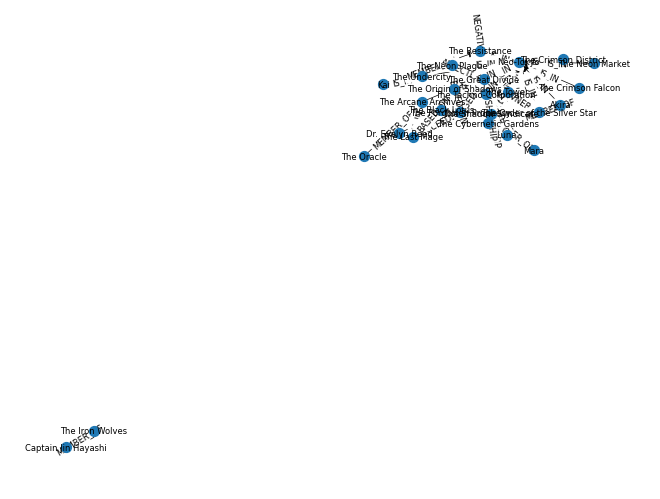

In [21]:
plot_graph(nodes_and_edges)

In [23]:
nodes_and_edges_selection = {
  "nodes": [
    ["Akira", {"label": "Character", "description": "A powerful psychic with immense destructive abilities."}],
    ["Neo-Tokyo", {"label": "Place", "description": "A sprawling metropolis in a dystopian future."}],
    ["The Tower", {"label": "Building", "description": "A massive skyscraper that serves as the seat of power for the ruling elite."}],
    ["The Shadow Syndicate", {"label": "Organization", "description": "A powerful criminal organization that controls the underworld of Neo-Tokyo."}],
    ["The Great Divide", {"label": "Drama", "description": "A deepening rift between the rich and the poor, leading to social unrest and rebellion."}],
    ["The Forgotten Prophecy", {"label": "Myth", "description": "A prophecy foretelling the return of ancient magic and the downfall of the ruling elite."}],
    ["The Last Mage", {"label": "Myth", "description": "A legendary figure who possesses the power to restore magic to the world and bring balance."}]
  ],
  "edges": [
    ["Akira", "Neo-Tokyo", {"relation": "IS_IN"}],
    ["Neo-Tokyo", "The Tower", {"relation": "IS_IN"}],
    ["Neo-Tokyo", "The Shadow Syndicate", {"relation": "IS_IN"}],
    ["Neo-Tokyo", "The Great Divide", {"relation": "IS_IN"}],
    ["The Great Divide", "The Forgotten Prophecy", {"relation": "BASED_ON"}],
    ["The Forgotten Prophecy", "The Last Mage", {"relation": "BASED_ON"}]
  ]
}

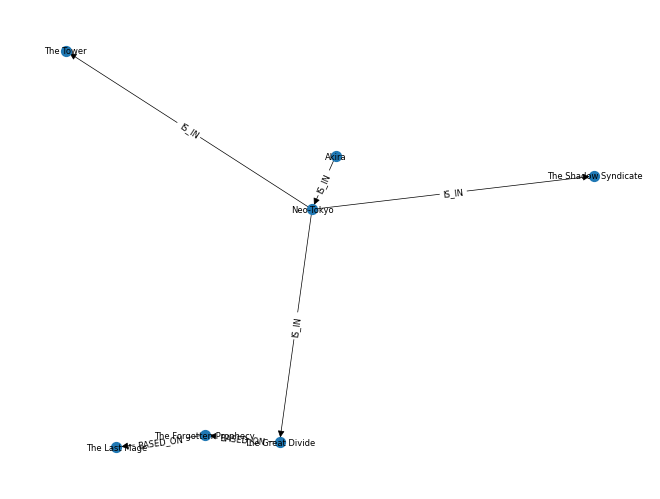

In [24]:
plot_graph(nodes_and_edges_selection)

In [30]:
from networkx.drawing.nx_agraph import graphviz_layout

# example data
node_attributes_dict = nodes_and_edges["nodes"]

edges = nodes_and_edges["edges"]

G = nx.DiGraph()

# Add nodes with attributes
for node_data in node_attributes_dict:
    node, attributes = node_data
    G.add_node(node, **attributes)

# Add edges with relation attributes
for source, target, attributes in edges:
    G.add_edge(source, target, **attributes)

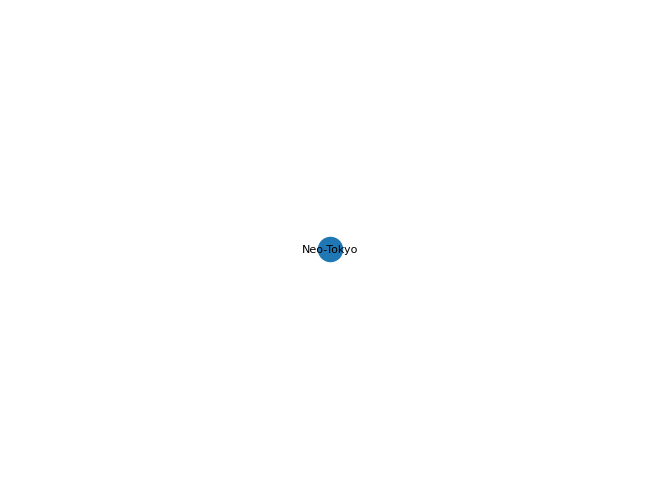

In [31]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_tree(G, root_node):
    # Create a tree from the root_node using breadth-first search
    tree = nx.bfs_tree(G, root_node)

    # Generate positions for the nodes using a shell layout
    pos = nx.shell_layout(tree)

    # Draw the tree using the positions
    nx.draw(tree, pos, with_labels=True, node_size=300, font_size=8, font_color='black', width=0.5)

    # Show the plot
    plt.show()

# Define your graph G here

# Draw the graph as a tree using the draw_tree function
draw_tree(G, root_node='Neo-Tokyo') # replace 'Neo-Tokyo' with the root node you want to use